In [1]:
import os 
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay


In [2]:

x = [1,2,3,4,5]
y = ['a','b','c','d','e']
random_seed =1000
print(shuffle(x,random_state=random_seed))
print(shuffle(y,random_state=random_seed))

[3, 2, 1, 5, 4]
['c', 'b', 'a', 'e', 'd']


In [3]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X:np.array, Y:np.array, batch_size: int=8,
                 input_size: int=128, shuffle: bool=True,
                 data_aug:bool=True):
        self.X = X
        self.Y =Y
        self.batch_size = batch_size
        self.IMG_SIZE =input_size
        self.shuffle = shuffle
        self.data_aug = data_aug
        
        self.augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.15)

        ])
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __img_preprocess(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [self.IMG_SIZE, self.IMG_SIZE])
        image = tf.cast(image, tf.float32) /255.0
        
        if self.data_aug:
            image = self.augmentation_pipeline(image)
        return image
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size: (idx+1)* self.batch_size]
        batch_y = self.Y[idx * self.batch_size: (idx+1)* self.batch_size]
        cur_X, cur_Y = self.__get_data(batch_x, batch_y)
        return cur_X, cur_Y
        
    def __get_data(self, x_batches, y_batches):
        X_batches = [self.__img_preprocess(x) for x in x_batches if self.__img_preprocess(x) is not None]
        return np.array(X_batches), np.array(y_batches)
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.X))
            np.random.shuffle(indices)
            self.X = self.X[indices]
            self.Y = self.Y[indices]
            

In [4]:
def create_label_encoder(dataset_path):
    classes = sorted(os.listdir(dataset_path))
    return {cls: [int(i==idx) for i in range(len(classes))] for idx, cls in enumerate(classes)}

In [5]:
def load_dataset(dataset_path: str, label_encode: dict):
    total_files = sum(len(files) for _,_, files in os.walk(dataset_path))
    
    x_data = np.empty(total_files, dtype=object)
    y_data = np.empty((total_files, len(label_encode)), dtype=int)
    
    index = 0
    for cur_class in os.listdir(dataset_path):
        temp_path = os.path.join(dataset_path, cur_class)
        for filename in os.listdir(temp_path):
            img_path = os.path.join(temp_path, filename)
            encoded_label = label_encode[cur_class]
            x_data[index] = img_path
            y_data[index] = encoded_label
            index += 1

    return x_data, y_data

In [6]:
# Paths
# Move two directories back
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
train_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "train")
test_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "validation")


In [7]:
# Label encoding
label_encode = create_label_encoder(train_path)
label_encode

{'cats': [1, 0], 'dogs': [0, 1]}

In [8]:
# Load datasets
x_train, y_train = load_dataset(train_path, label_encode)
x_test, y_test = load_dataset(test_path, label_encode)
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (2000,)
y_train: (2000, 2)
x_test: (1000,)
y_test: (1000, 2)


Label (one-hot encoded): [1 0]
Image shape: (128, 128, 3)


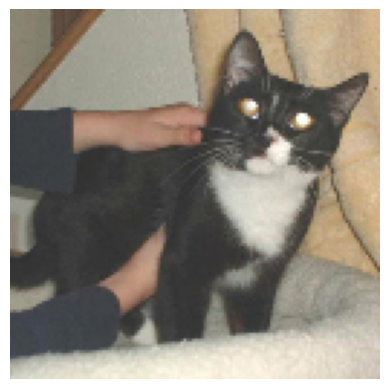

In [9]:
import matplotlib.pyplot as plt

batch_size = 16
input_size = 128
input_shape = (128,128,3)

# create data generators
train_gen = CustomDataGenerator(X=x_train, Y=y_train, batch_size=batch_size, input_size=input_size, shuffle=True, data_aug=True)
test_gen = CustomDataGenerator(X=x_test, Y=y_test, batch_size=batch_size, input_size=input_size, shuffle=False, data_aug=False)

# Fetch one batch
test_images, test_labels = next(iter(test_gen))

# Display the first image
print("Label (one-hot encoded):", test_labels[0])
print("Image shape:", test_images[0].shape)

plt.imshow(test_images[0])
plt.axis("off")
plt.show()

In [10]:

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Cats & Dogs
])

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=1e-4),
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                      

In [12]:
epochs = 20
# def lr_scheduler(epoch, lr):
#     decay_rate = 0.9
#     min_lr = 1e-6  # Set a floor for the learning rate
#     new_lr = max(base_learning_rate * (decay_rate ** epoch), min_lr)
#     print(f"[+] Epoch {epoch + 1}/{epochs} - Current LR: {new_lr}")
#     return new_lr
# base_learning_rate = 1e-3
# def lr_scheduler(epoch, lr):
#     total_epochs = epochs
    
#     check_1 = int(total_epochs*0.9)
#     check_2 = int(total_epochs*0.7)
#     check_3 = int(total_epochs*0.5)
#     check_4 = int(total_epochs*0.3)

#     if epoch > check_1:
#         lr =  1e-5 # 0.000001
#     elif  epoch > check_2:
#         lr = 1e-4
#     elif  epoch > check_3:
#         lr = 1e-3

#     else:
#         lr = 1e-2

#     print("[+] Current LR rate : {}".format(lr))
#     return lr

initial_learning_rate = 5e-4
decay_steps = 1000  # Number of steps before applying decay
decay_rate = 0.96   # Decay factor

lr_scheduler = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)
# TensorFlow Callback
custom_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [13]:
# Path to logs/fit directory
log_dir = os.path.join(base_path, "logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))

os.makedirs(log_dir, exist_ok=True)

# TensorBoard callback
tf_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [14]:
history = model.fit(train_gen,validation_data=test_gen,epochs=20,verbose=1,
                    callbacks = [tf_board_callback,custom_lr_callback])

Epoch 1/20
125/125 [==============================] - 36s 269ms/step - loss: 1.1013 - accuracy: 0.5500 - val_loss: 1.3641 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 2/20
125/125 [==============================] - 34s 270ms/step - loss: 0.9702 - accuracy: 0.5690 - val_loss: 0.8533 - val_accuracy: 0.4960 - lr: 5.0000e-04
Epoch 3/20
125/125 [==============================] - 33s 267ms/step - loss: 0.8476 - accuracy: 0.5915 - val_loss: 1.0431 - val_accuracy: 0.4970 - lr: 5.0000e-04
Epoch 4/20
125/125 [==============================] - 34s 271ms/step - loss: 0.8207 - accuracy: 0.5865 - val_loss: 0.7049 - val_accuracy: 0.6040 - lr: 5.0000e-04
Epoch 5/20
125/125 [==============================] - 33s 264ms/step - loss: 0.7492 - accuracy: 0.6085 - val_loss: 0.8450 - val_accuracy: 0.6000 - lr: 5.0000e-04
Epoch 6/20
125/125 [==============================] - 34s 270ms/step - loss: 0.7194 - accuracy: 0.6175 - val_loss: 0.7767 - val_accuracy: 0.6280 - lr: 5.0000e-04
Epoch 7/20
125/125 [========